In [1]:
#libraries
from scipy import stats
import pandas as pd
import numpy as np
from numpy import arange
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict,cross_val_score, RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import datasets, linear_model
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import classification_report, mean_squared_error
#from regressors import stats 
from gplearn.genetic import SymbolicRegressor
from sympy import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math
import statsmodels.formula.api as smf 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.feature_selection import SelectKBest, f_regression

Loading in inital raw data and performing exploratory analysis on it.

In [2]:
Data = pd.read_csv("Project1_Dataset/SeoulBikeData.csv", encoding='latin1')

In [3]:
Data.head()

,Date,Hour,Temperature,Humidity,WindSpeed,Visibility,Dew point temperature,SolarRadiation,Rainfall,Snowfall,Seasons,Holiday,FunctioningDay,Rented Bike Count
0,1/12/2017,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,254
1,1/12/2017,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,204
2,1/12/2017,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,173
3,1/12/2017,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,107
4,1/12/2017,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,78


In [4]:
# drop date 
Data.drop(columns=['Date'], inplace=True)

# encoding
Data['Seasons'] = pd.Categorical(Data['Seasons']).codes
Data['Holiday'] = pd.Categorical(Data['Holiday']).codes
Data['FunctioningDay'] = pd.Categorical(Data['FunctioningDay']).codes

Data.describe().round(2)

,Hour,Temperature,Humidity,WindSpeed,Visibility,Dew point temperature,SolarRadiation,Rainfall,Snowfall,Seasons,Holiday,FunctioningDay,Rented Bike Count
count,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00
mean,11.50,12.88,58.23,1.72,1436.83,4.07,0.57,0.15,0.08,1.50,0.95,0.97,704.60
std,6.92,11.94,20.36,1.04,608.30,13.06,0.87,1.13,0.44,1.11,0.22,0.18,645.00
min,0.00,-17.80,0.00,0.00,27.00,-30.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.75,3.50,42.00,0.90,940.00,-4.70,0.00,0.00,0.00,1.00,1.00,1.00,191.00
50%,11.50,13.70,57.00,1.50,1698.00,5.10,0.01,0.00,0.00,1.00,1.00,1.00,504.50
75%,17.25,22.50,74.00,2.30,2000.00,14.80,0.93,0.00,0.00,2.00,1.00,1.00,1065.25
max,23.00,39.40,98.00,7.40,2000.00,27.20,3.52,35.00,8.80,3.00,1.00,1.00,3556.00


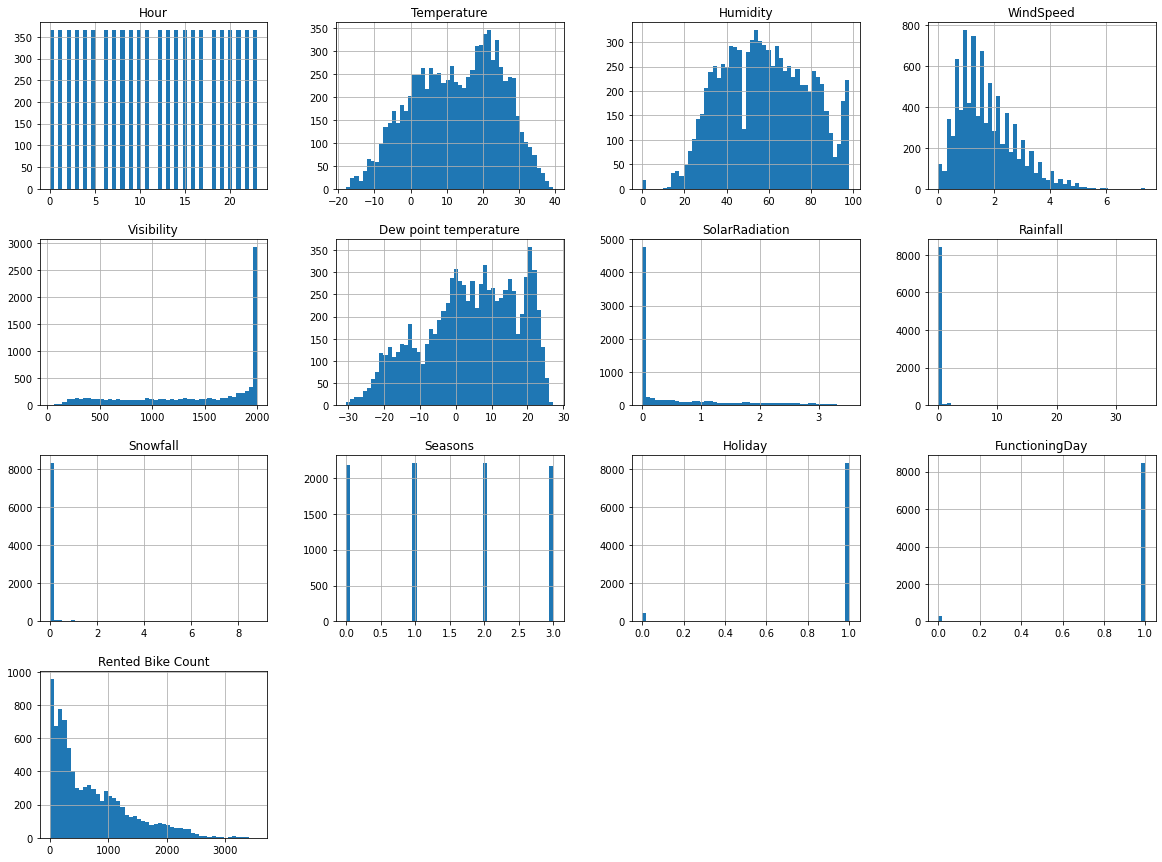

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
Data.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:title={'center':'Rented Bike Count'}, xlabel='[FunctioningDay]'>

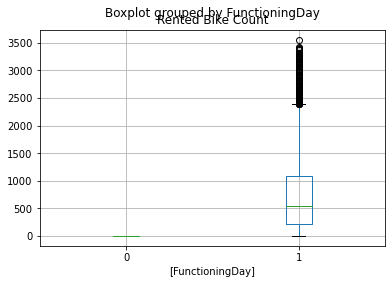

In [6]:
Data.boxplot(column = ['Rented Bike Count'], by = ['FunctioningDay'])

<AxesSubplot:title={'center':'Rented Bike Count'}, xlabel='[Holiday]'>

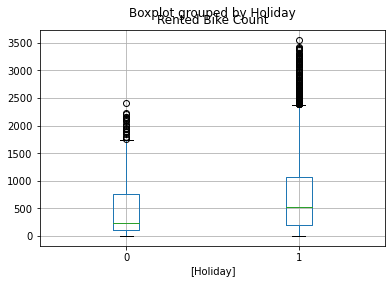

In [7]:
Data.boxplot(column = ['Rented Bike Count'], by = ['Holiday'])

<AxesSubplot:title={'center':'Rented Bike Count'}, xlabel='[Seasons]'>

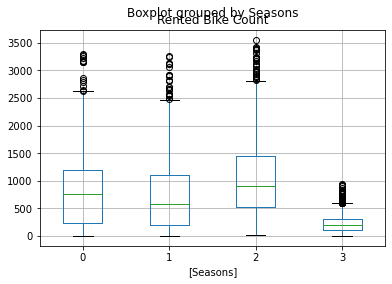

In [8]:
Data.boxplot(column = ['Rented Bike Count'], by = ['Seasons'])

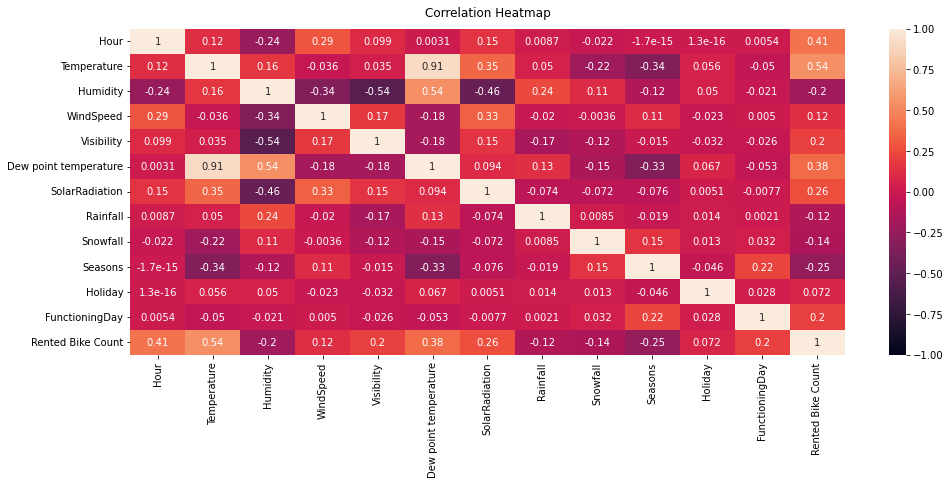

In [9]:
import seaborn as sns

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(Data.corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [10]:
# drop multicolinear columns
Data.drop(columns=['Temperature', 'Humidity', 'Dew point temperature'], inplace = True)

In [11]:
# Splitting the data
x = Data[["Hour", "WindSpeed", "Visibility","SolarRadiation", "Rainfall", "Snowfall", "Seasons", "Holiday", 
           "FunctioningDay"]]
y = Data[['Rented Bike Count']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# R2 and Adj R2 calculated and plotted against combinations of features

In [12]:
NUM_FEATURES = ["Hour", "WindSpeed", "Visibility","SolarRadiation", "Rainfall", "Snowfall", "Seasons", "Holiday", 
                "FunctioningDay"] 

num_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),   
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, NUM_FEATURES),
], remainder='drop')




rCVscores=[] 
r2scores =[]
adjustedr2 = []
feature_names=[]
for i in range(1, 10):   
    reduce_dim_pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('reduce_dim', SelectKBest(k=i, score_func=f_regression)),       
    ])
    
    pipeline = Pipeline(steps=[
        ('reduce_dim_pipe', reduce_dim_pipe),       
        ('regress', LinearRegression())
    ])
    
    
    #calculate cross validated R2
    R2 = cross_val_score(pipeline, X=x_train, y=y_train,cv=5, scoring='r2').mean()    
    rCVscores.append(R2)
    
    #calculate R2
    predicted = cross_val_predict(pipeline,X=x_train, y=y_train, cv=5) 
    r2=r2_score(y_train, predicted)
    r2scores.append(r2)
        
    #calculate Adj R2
    n= len(x_train)
    p = i
    adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1)) #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)
    adjustedr2.append(adj_R2)
    
    reduce_dim_pipe.fit(X=x_train, y=y_train)
    # Get columns to keep    
    cols = reduce_dim_pipe.named_steps['reduce_dim'].get_support(indices=True)
    # Create new dataframe with only desired columns
    features_df_new = x_train.iloc[:, cols]
    best_features = list(features_df_new.columns)
    feature_names.append(best_features)

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [13]:
scoring_df = pd.DataFrame(np.column_stack((rCVscores,r2scores, adjustedr2)), columns=['R2CV','R2', 'Adj_R2']) 
scoring_df['feature_names'] = feature_names
scoring_df['features'] = range(1, 10)
scoring_df

,R2CV,R2,Adj_R2,feature_names,features
0,0.165106,0.164957,0.164837,[Hour],1
1,0.204834,0.204690,0.204463,"[Hour, SolarRadiation]",2
2,0.261416,0.261171,0.260855,"[Hour, SolarRadiation, Seasons]",3
3,0.331023,0.330879,0.330497,"[Hour, SolarRadiation, Seasons, FunctioningDay]",4
4,0.349888,0.349816,0.349352,"[Hour, Visibility, SolarRadiation, Seasons, Fu...",5
5,0.355162,0.355093,0.354541,"[Hour, Visibility, SolarRadiation, Snowfall, S...",6
6,0.358943,0.358779,0.358138,"[Hour, WindSpeed, Visibility, SolarRadiation, ...",7
7,0.364826,0.364817,0.364091,"[Hour, WindSpeed, Visibility, SolarRadiation, ...",8
8,0.368958,0.368894,0.368082,"[Hour, WindSpeed, Visibility, SolarRadiation, ...",9


adjustedr2
[0.16483744876184458, 0.20446285786616436, 0.26085466028785986, 0.33049715417329617, 0.3493517091518836, 0.354540622031725, 0.3581375646339866, 0.36409053364042643, 0.3680819683073704]
r2scores
[0.1651061390230248, 0.20483351815582082, 0.2614159429464157, 0.3310234983096573, 0.3498880677219529, 0.3551618267891729, 0.35894297461467184, 0.36482643940361525, 0.3689584991511018]
rCVscores
[0.1649566385079897, 0.2046899271232313, 0.26117112040190815, 0.3308793450371904, 0.34981599364656624, 0.35509332022892914, 0.3587787858481385, 0.3648165612886177, 0.3688936226937317]


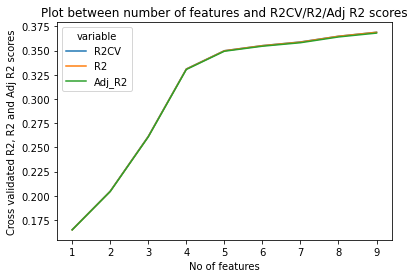

In [14]:
fig, ax = plt.subplots(figsize=(6, 4)) 
long_format_df = pd.melt(scoring_df.loc[:, ['features','R2CV','R2', 'Adj_R2']], ['features'])
sns.lineplot(x='features', y='value', hue='variable', data=long_format_df, ax=ax)
ax.set_xlabel('No of features')
ax.set_ylabel('Cross validated R2, R2 and Adj R2 scores')
ax.set_title('Plot between number of features and R2CV/R2/Adj R2 scores')

print('adjustedr2')
print(adjustedr2)
print('r2scores')
print(rCVscores)
print('rCVscores')
print(r2scores)

# Linear Regression

In [15]:
#adding in intercept
Data.insert(0, "intercept", 1)
Data.head()

,intercept,Hour,WindSpeed,Visibility,SolarRadiation,Rainfall,Snowfall,Seasons,Holiday,FunctioningDay,Rented Bike Count
0,1,0,2.2,2000,0.0,0.0,0.0,3,1,1,254
1,1,1,0.8,2000,0.0,0.0,0.0,3,1,1,204
2,1,2,1.0,2000,0.0,0.0,0.0,3,1,1,173
3,1,3,0.9,2000,0.0,0.0,0.0,3,1,1,107
4,1,4,2.3,2000,0.0,0.0,0.0,3,1,1,78


In [16]:
# Splitting the data for linear w/ intercept
x = Data[["intercept", "Hour", "WindSpeed", "Visibility","SolarRadiation", "Rainfall", "Snowfall", "Seasons", "Holiday", 
           "FunctioningDay"]]
y = Data[['Rented Bike Count']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [17]:
# Linear Regression using statmodels since scikit doesn't produce summary table like below
LMModel = sm.OLS(y_train, x_train).fit()
y_pred = LMModel.predict(x_test)
LMModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     469.6
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:56:37   Log-Likelihood:                -53615.
No. Observations:                7008   AIC:                         1.072e+05
Df Residuals:                    6998   BIC:                         1.073e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       -779.1874     47.184    -16.514      0.000    -871.682    -686.693
Hour              35.7264      0.918     38.903      0.000      33.926      37.527
WindSpeed        -23.8211      6.529     -3.648      0.000     -36.620     -11.022
Visibility         0.1219      0.010     11.625      0.000       0.101       0.142
SolarRadiation   126.3350      7.548     16.739      0.000     111.540     141.130
Rainfall         -60.6273      5.652    -10.727      0.000     -71.706     -49.548
Snowfall        -109.6520     14.332     -7.651      0.000    -137.746     -81.558
Seasons         -167.5113      5.719    -29.290      0.000    -178.723    -156.300
Holiday          188.8788     28.312      6.671      0.000     133.378     244.380
FunctioningDay   987.2166     35.383     27.901      0.000     917.854    1056.579
==============================================================================
Omnibus:                     1393.254   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2737.971
Skew:                           1.201   Prob(JB):                         0.00
Kurtosis:                       4.900   Cond. No.                     1.44e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Feature Selection using Sequential Forward, backward and stepwise techniques

In [18]:
# Sequential Forward Selection(sfs)
sfs = sfs(LinearRegression(),
          k_features=3,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 5)
sfs.fit(x, y)
sfs.k_feature_names_  

('SolarRadiation', 'Snowfall', 'Seasons')

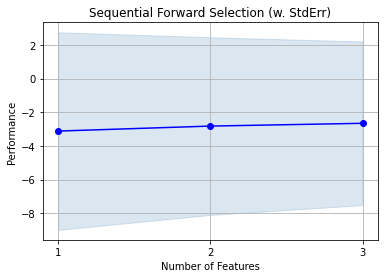

In [19]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [20]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#Sequential backward selection(sbs)
sbs = sfs(LinearRegression(),
         k_features=3,
         forward=False,
         floating=False,
         cv=5)
sbs.fit(x, y)
sbs.k_feature_names_

('SolarRadiation', 'Seasons', 'FunctioningDay')

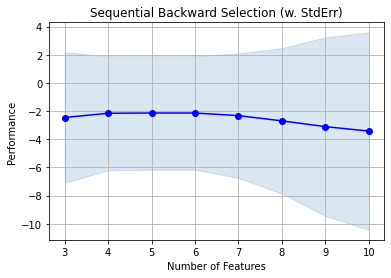

In [21]:
fig2 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [22]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# Sequential Forward Floating Selection(sffs) stepwise
sffs = sfs(LinearRegression(),
         k_features=(1, 10),
         forward=True,
         floating=True,
         cv=5)
sffs.fit(x, y)
sffs.k_feature_names_

('SolarRadiation', 'Snowfall', 'Seasons', 'Holiday', 'FunctioningDay')

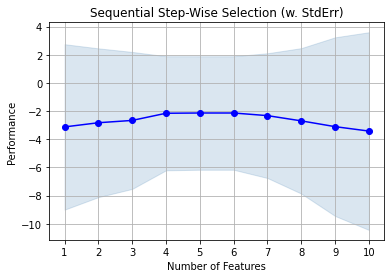

In [23]:
fig3 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Step-Wise Selection (w. StdErr)')
plt.grid()
plt.show()

eval_env: 1


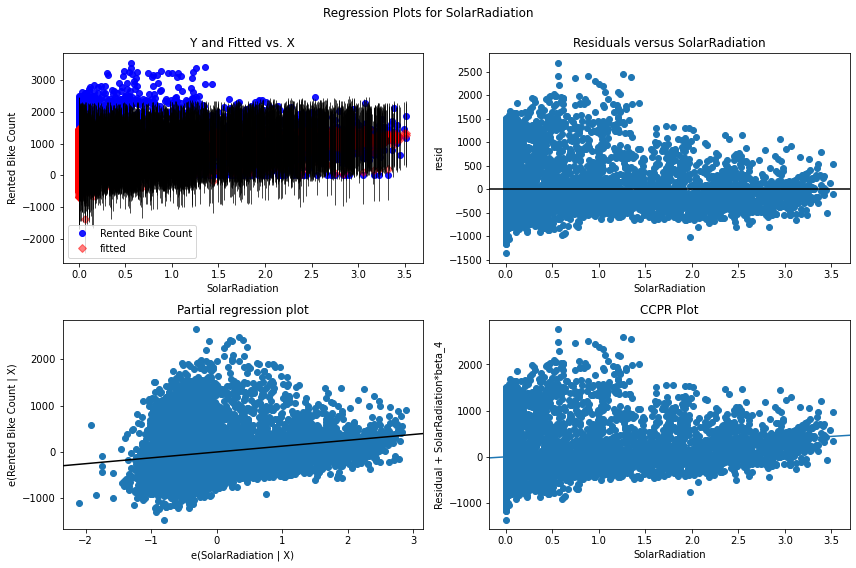

In [24]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(LMModel, "SolarRadiation", fig=fig)

eval_env: 1


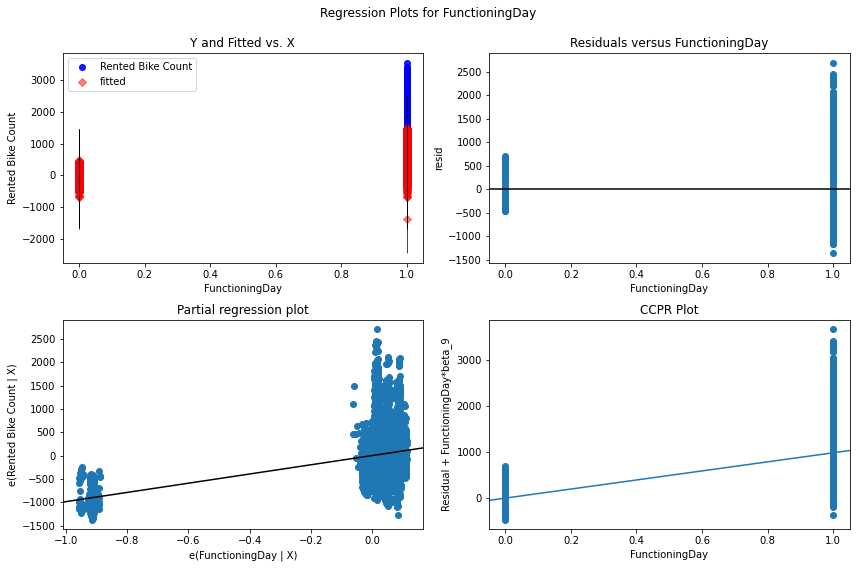

In [25]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(LMModel, "FunctioningDay", fig=fig)

eval_env: 1


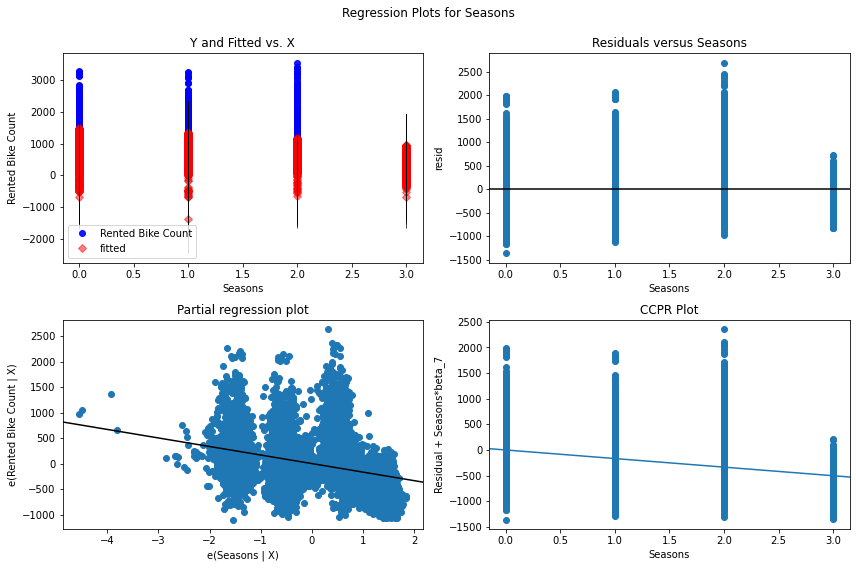

In [26]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(LMModel, "Seasons", fig=fig)

## Linear Regression Summary Stat & Cross Validation

In [27]:
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.estimator_checks import check_estimator



class MyLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True):

        self.fit_intercept = fit_intercept


    """
    Parameters
    ------------
    column_names: list
            It is an optional value, such that this class knows 
            what is the name of the feature to associate to 
            each column of X. This is useful if you use the method
            summary(), so that it can show the feature name for each
            coefficient
    """ 
    def fit(self, X, y, column_names=() ):

        if self.fit_intercept:
            X = sm.add_constant(X)

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)


        self.X_ = X
        self.y_ = y

        if len(column_names) != 0:
            cols = column_names.copy()
            cols = list(cols)
            X = pd.DataFrame(X)
            cols = column_names.copy()
            cols.insert(0,'intercept')
            print('X ', X)
            X.columns = cols

        self.model_ = sm.OLS(y, X)
        self.results_ = self.model_.fit()
        return self



    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, 'model_')

        # Input validation
        X = check_array(X)

        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)


    def get_params(self, deep = False):
        return {'fit_intercept':self.fit_intercept}


    def summary(self):
        print(self.results_.summary() )


In [28]:
cols =['Hour', 'WindSpeed', 'FunctioningDay', 'Seasons','Snowfall', 'Holiday', 'Rainfall', 'SolarRadiation', 'Visibility']

X_train = x_train[cols].values
X_test = x_test[cols].values
Y_train = y_train['Rented Bike Count']
Y_test = y_test['Rented Bike Count']
model = MyLinearRegression()
model.fit(X_train, Y_train)
model.summary()
# Compare predicted values with actual values
Predictions = pd.DataFrame()
Predictions['Linear Regression'] = LMPred = model.predict(X_test)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     469.6
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:56:45   Log-Likelihood:                -53615.
No. Observations:                7008   AIC:                         1.072e+05
Df Residuals:                    6998   BIC:                         1.073e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -779.1874     47.184    -16.514      0.0

In [29]:
R_Squared_CV = []
from sklearn.model_selection import cross_val_score
scores = cross_val_score(MyLinearRegression(), X_train, Y_train, cv=7, scoring='r2')
scores

array([0.40291361, 0.37455219, 0.36218899, 0.38975796, 0.36950562,
       0.35699012, 0.36617728])

In [30]:
# Create an array that contains RMSE for all the models
ModelNames = ['Linear Reg']
RMSE = mean_squared_error(Y_test, LMPred, squared = False)

# Transformed Regression

### Square Root

In [31]:
Data

,intercept,Hour,WindSpeed,Visibility,SolarRadiation,Rainfall,Snowfall,Seasons,Holiday,FunctioningDay,Rented Bike Count
0,1,0,2.2,2000,0.0,0.0,0.0,3,1,1,254
1,1,1,0.8,2000,0.0,0.0,0.0,3,1,1,204
2,1,2,1.0,2000,0.0,0.0,0.0,3,1,1,173
3,1,3,0.9,2000,0.0,0.0,0.0,3,1,1,107
4,1,4,2.3,2000,0.0,0.0,0.0,3,1,1,78
...,...,...,...,...,...,...,...,...,...,...,...
8755,1,19,2.6,1894,0.0,0.0,0.0,0,1,1,1003
8756,1,20,2.3,2000,0.0,0.0,0.0,0,1,1,764
8757,1,21,0.3,1968,0.0,0.0,0.0,0,1,1,694
8758,1,22,1.0,1859,0.0,0.0,0.0,0,1,1,712


In [32]:
import math
NewY = y["Rented Bike Count"].apply(lambda x:math.sqrt(x))

X_train, X_test, Y_train, Y_test = train_test_split(x, NewY, test_size = 0.2, random_state = 2)


In [33]:
# Transformed Regression 
TRModel = sm.OLS(Y_train, X_train).fit()
TRModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     704.2
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:56:45   Log-Likelihood:                -25357.
No. Observations:                7008   AIC:                         5.073e+04
Df Residuals:                    6998   BIC:                         5.080e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        -14.0941      0.821    -17.169      0.000     -15.703     -12.485
Hour               0.6407      0.016     39.277      0.000       0.609       0.673
WindSpeed         -0.6534      0.116     -5.639      0.000      -0.880      -0.426
Visibility         0.0024      0.000     13.147      0.000       0.002       0.003
SolarRadiation     3.0583      0.134     22.809      0.000       2.795       3.321
Rainfall          -1.4252      0.094    -15.223      0.000      -1.609      -1.242
Snowfall          -2.5601      0.249    -10.268      0.000      -3.049      -2.071
Seasons           -3.2524      0.102    -31.799      0.000      -3.453      -3.052
Holiday            3.5504      0.498      7.128      0.000       2.574       4.527
FunctioningDay    28.9985      0.620     46.780      0.000      27.783      30.214
==============================================================================
Omnibus:                      264.389   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.579
Skew:                           0.488   Prob(JB):                     1.08e-64
Kurtosis:                       3.233   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
#rescale sqrt for graph
Predictions['Transformed Regression: sqrt'] = TRPred = TRModel.predict(X_test).apply(lambda x:(x**2)).to_numpy()

In [35]:
# # retraining model without intercept for scalable rmse calculations
# NewY = y["Rented Bike Count"].apply(lambda x:math.sqrt(x))
# X_train, X_test, Y_train, Y_test = train_test_split(x, NewY, test_size = 0.2, random_state = 2)
# TRModel_0 = sm.OLS(Y_train, X_train).fit()
# TRPred_0 = TRModel_0.predict(X_test)
# Append RMSE for all the models
ModelNames.append('Transformed Reg: sqrt')

# Add RMSE
RMSE = np.append(RMSE, mean_squared_error(Y_test, TRPred, squared = False))

### Quadratic

In [36]:
QuadY = y["Rented Bike Count"].apply(lambda x:(x**2))

X_train, X_test, Y_train, Y_test = train_test_split(x, QuadY, test_size = 0.2, random_state = 2)

In [37]:
TRModelQuad = sm.OLS(Y_train, X_train).fit()
TRModelQuad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     222.7
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:56:45   Log-Likelihood:            -1.0861e+05
No. Observations:                7008   AIC:                         2.172e+05
Df Residuals:                    6998   BIC:                         2.173e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -1.492e+06   1.18e+05    -12.592      0.000   -1.72e+06   -1.26e+06
Hour            7.443e+04   2354.059     31.617      0.000    6.98e+04     7.9e+04
WindSpeed      -4284.2938   1.67e+04     -0.256      0.798   -3.71e+04    2.85e+04
Visibility       266.0623     26.582     10.009      0.000     213.953     318.171
SolarRadiation  1.028e+05   1.93e+04      5.313      0.000    6.49e+04    1.41e+05
Rainfall       -7.776e+04   1.35e+04     -5.755      0.000   -1.04e+05   -5.13e+04
Snowfall       -1.801e+05    3.6e+04     -5.005      0.000   -2.51e+05    -1.1e+05
Seasons        -2.619e+05   1.48e+04    -17.742      0.000   -2.91e+05   -2.33e+05
Holiday         2.812e+05   7.19e+04      3.912      0.000     1.4e+05    4.22e+05
FunctioningDay  1.314e+06   8.95e+04     14.685      0.000    1.14e+06    1.49e+06
==============================================================================
Omnibus:                     4049.156   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40696.246
Skew:                           2.632   Prob(JB):                         0.00
Kurtosis:                      13.567   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cubic

In [38]:
CubeY = y["Rented Bike Count"].apply(lambda x:(x**3))

X_train, X_test, Y_train, Y_test = train_test_split(x, CubeY, test_size = 0.2, random_state = 2)

In [39]:
TRModelCube = sm.OLS(Y_train, X_train).fit()
TRModelCube.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     123.8
Date:                Sun, 19 Feb 2023   Prob (F-statistic):          6.62e-217
Time:                        18:56:45   Log-Likelihood:            -1.6364e+05
No. Observations:                7008   AIC:                         3.273e+05
Df Residuals:                    6998   BIC:                         3.274e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept      -3.126e+09   3.05e+08    -10.261      0.000   -3.72e+09   -2.53e+09
Hour            1.531e+08   6.05e+06     25.288      0.000    1.41e+08    1.65e+08
WindSpeed       5.715e+07    4.3e+07      1.329      0.184   -2.71e+07    1.41e+08
Visibility      5.665e+05   6.84e+04      8.286      0.000    4.32e+05       7e+05
SolarRadiation  2.946e+06   4.98e+07      0.059      0.953   -9.46e+07       1e+08
Rainfall        -1.36e+08   3.47e+07     -3.914      0.000   -2.04e+08   -6.79e+07
Snowfall       -3.296e+08   9.25e+07     -3.562      0.000   -5.11e+08   -1.48e+08
Seasons        -4.278e+08    3.8e+07    -11.271      0.000   -5.02e+08   -3.53e+08
Holiday         6.054e+08   1.85e+08      3.275      0.001    2.43e+08    9.68e+08
FunctioningDay   2.18e+09    2.3e+08      9.476      0.000    1.73e+09    2.63e+09
==============================================================================
Omnibus:                     6573.544   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           310445.868
Skew:                           4.511   Prob(JB):                         0.00
Kurtosis:                      34.333   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Ridge Regression

In [40]:
#removing intercept as model already accounts for it
Data.drop(columns=['intercept'], inplace=True)

In [41]:
# Splitting the data
x = Data[["Hour", "WindSpeed", "Visibility","SolarRadiation", "Rainfall", "Snowfall", "Seasons", "Holiday", 
           "FunctioningDay"]]
y = Data[['Rented Bike Count']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [42]:
#Grid search cross validation for best alpha
pipeline = Pipeline([
                     ('model',Ridge())
])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,1,0.1)},
                      cv = 5, scoring="r2",verbose=3
                      )
search.fit(x_train,y_train)

#return best alpha value
search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..................model__alpha=0.1;, score=0.343 total time=   0.0s
[CV 2/5] END ..................model__alpha=0.1;, score=0.397 total time=   0.0s
[CV 3/5] END ..................model__alpha=0.1;, score=0.374 total time=   0.0s
[CV 4/5] END ..................model__alpha=0.1;, score=0.376 total time=   0.0s
[CV 5/5] END ..................model__alpha=0.1;, score=0.377 total time=   0.0s
[CV 1/5] END ..................model__alpha=0.2;, score=0.343 total time=   0.0s
[CV 2/5] END ..................model__alpha=0.2;, score=0.397 total time=   0.0s
[CV 3/5] END ..................model__alpha=0.2;, score=0.374 total time=   0.0s
[CV 4/5] END ..................model__alpha=0.2;, score=0.376 total time=   0.0s
[CV 5/5] END ..................model__alpha=0.2;, score=0.377 total time=   0.0s
[CV 1/5] END ..model__alpha=0.30000000000000004;, score=0.343 total time=   0.0s
[CV 2/5] END ..model__alpha=0.30000000000000004;,

{'model__alpha': 0.9}

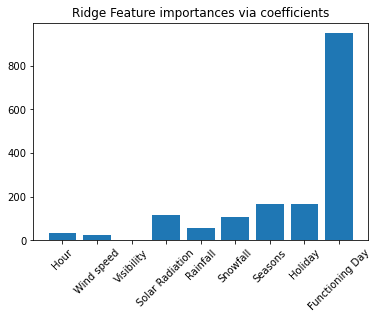

In [43]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

fname = ["Hour", "Wind speed", "Visibility","Solar Radiation", "Rainfall", "Snowfall", "Seasons", "Holiday", 
           "Functioning Day"]
feature_names = np.array(fname)
plt.bar(height=importance.reshape(9), x=feature_names)
plt.xticks(rotation = 45)
plt.title("Ridge Feature importances via coefficients")
plt.show()

In [44]:
#Ridge regression with built-in cross-validation
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# define model, Flagging Alpha_per_Target to True indicating  to optimize the alpha value...after fitting, the alpha_ attribute will contain a value for each target.
model = RidgeCV(alphas=arange(0.1, 10, 0.1), cv=cv, scoring='r2')

# fit model
# fit model using importnt features 
x_trainrr = x_train[['FunctioningDay', 'Seasons', 'Holiday']].copy() 
x_testrr = x_test[['FunctioningDay', 'Seasons', 'Holiday']].copy()
RRModel = model.fit(x_trainrr, y_train)


# summarize chosen configuration
print('alpha_: %f' % model.alpha_)
print('r_squared: %f' % model.best_score_)

alpha_: 0.400000
r_squared: 0.140780


In [45]:
# Ridge Regression Coefficients
RRModel.coef_

array([[ 969.46015217, -182.53490858,  161.22659757]])

In [46]:
#Add Ridge Regression Predicted Values
Predictions['Ridge Regression'] = RRPred = RRModel.predict(x_testrr)

In [47]:
# Append RMSE for all the models
ModelNames.append('Ridge Reg')

# Add RMSE
RMSE = np.append(RMSE,mean_squared_error(y_test, RRPred, squared = False))

# Lasso Regression

In [48]:
#Feature Importance using Lasso and gridsearchCV

pipeline = Pipeline([
                     ('model',Lasso())
])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="r2",verbose=3
                      )
search.fit(x_train,y_train)
#The best value for α is:
search.best_params_

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ..................model__alpha=0.1;, score=0.343 total time=   0.0s
[CV 2/5] END ..................model__alpha=0.1;, score=0.397 total time=   0.0s
[CV 3/5] END ..................model__alpha=0.1;, score=0.374 total time=   0.0s
[CV 4/5] END ..................model__alpha=0.1;, score=0.376 total time=   0.0s
[CV 5/5] END ..................model__alpha=0.1;, score=0.377 total time=   0.0s
[CV 1/5] END ..................model__alpha=0.2;, score=0.343 total time=   0.0s
[CV 2/5] END ..................model__alpha=0.2;, score=0.397 total time=   0.0s
[CV 3/5] END ..................model__alpha=0.2;, score=0.374 total time=   0.0s
[CV 4/5] END ..................model__alpha=0.2;, score=0.376 total time=   0.0s
[CV 5/5] END ..................model__alpha=0.2;, score=0.377 total time=   0.0s
[CV 1/5] END ..model__alpha=0.30000000000000004;, score=0.343 total time=   0.0s
[CV 2/5] END ..model__alpha=0.30000000000000004

[CV 4/5] END ..................model__alpha=2.1;, score=0.375 total time=   0.0s
[CV 5/5] END ..................model__alpha=2.1;, score=0.377 total time=   0.0s
[CV 1/5] END ..................model__alpha=2.2;, score=0.342 total time=   0.0s
[CV 2/5] END ..................model__alpha=2.2;, score=0.397 total time=   0.0s
[CV 3/5] END ..................model__alpha=2.2;, score=0.374 total time=   0.0s
[CV 4/5] END ..................model__alpha=2.2;, score=0.375 total time=   0.0s
[CV 5/5] END ..................model__alpha=2.2;, score=0.377 total time=   0.0s
[CV 1/5] END ...model__alpha=2.3000000000000003;, score=0.342 total time=   0.0s
[CV 2/5] END ...model__alpha=2.3000000000000003;, score=0.397 total time=   0.0s
[CV 3/5] END ...model__alpha=2.3000000000000003;, score=0.373 total time=   0.0s
[CV 4/5] END ...model__alpha=2.3000000000000003;, score=0.375 total time=   0.0s
[CV 5/5] END ...model__alpha=2.3000000000000003;, score=0.377 total time=   0.0s
[CV 1/5] END ...model__alpha

[CV 1/5] END ..................model__alpha=4.3;, score=0.340 total time=   0.0s
[CV 2/5] END ..................model__alpha=4.3;, score=0.396 total time=   0.0s
[CV 3/5] END ..................model__alpha=4.3;, score=0.372 total time=   0.0s
[CV 4/5] END ..................model__alpha=4.3;, score=0.374 total time=   0.0s
[CV 5/5] END ..................model__alpha=4.3;, score=0.375 total time=   0.0s
[CV 1/5] END ...model__alpha=4.3999999999999995;, score=0.340 total time=   0.0s
[CV 2/5] END ...model__alpha=4.3999999999999995;, score=0.396 total time=   0.0s
[CV 3/5] END ...model__alpha=4.3999999999999995;, score=0.371 total time=   0.0s
[CV 4/5] END ...model__alpha=4.3999999999999995;, score=0.373 total time=   0.0s
[CV 5/5] END ...model__alpha=4.3999999999999995;, score=0.375 total time=   0.0s
[CV 1/5] END ..................model__alpha=4.5;, score=0.340 total time=   0.0s
[CV 2/5] END ..................model__alpha=4.5;, score=0.395 total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END ..................model__alpha=6.4;, score=0.336 total time=   0.0s
[CV 2/5] END ..................model__alpha=6.4;, score=0.393 total time=   0.0s
[CV 3/5] END ..................model__alpha=6.4;, score=0.368 total time=   0.0s
[CV 4/5] END ..................model__alpha=6.4;, score=0.370 total time=   0.0s
[CV 5/5] END ..................model__alpha=6.4;, score=0.371 total time=   0.0s
[CV 1/5] END ..................model__alpha=6.5;, score=0.336 total time=   0.0s
[CV 2/5] END ..................model__alpha=6.5;, score=0.393 total time=   0.0s
[CV 3/5] END ..................model__alpha=6.5;, score=0.368 total time=   0.0s
[CV 4/5] END ..................model__alpha=6.5;, score=0.370 total time=   0.0s
[CV 5/5] END ..................model__alpha=6.5;, score=0.371 total time=   0.0s
[CV 1/5] END ..................model__alpha=6.6;, score=0.336 total time=   0.0s
[CV 2/5] END ..................model__alpha=6.6;, score=0.393 total time=   0.0s
[CV 3/5] END ...............

[CV 2/5] END ..................model__alpha=8.6;, score=0.389 total time=   0.0s
[CV 3/5] END ..................model__alpha=8.6;, score=0.364 total time=   0.0s
[CV 4/5] END ..................model__alpha=8.6;, score=0.365 total time=   0.0s
[CV 5/5] END ..................model__alpha=8.6;, score=0.367 total time=   0.0s
[CV 1/5] END ..................model__alpha=8.7;, score=0.331 total time=   0.0s
[CV 2/5] END ..................model__alpha=8.7;, score=0.389 total time=   0.0s
[CV 3/5] END ..................model__alpha=8.7;, score=0.364 total time=   0.0s
[CV 4/5] END ..................model__alpha=8.7;, score=0.365 total time=   0.0s
[CV 5/5] END ..................model__alpha=8.7;, score=0.367 total time=   0.0s
[CV 1/5] END ..................model__alpha=8.8;, score=0.331 total time=   0.0s
[CV 2/5] END ..................model__alpha=8.8;, score=0.388 total time=   0.0s
[CV 3/5] END ..................model__alpha=8.8;, score=0.363 total time=   0.0s
[CV 4/5] END ...............

{'model__alpha': 0.1}

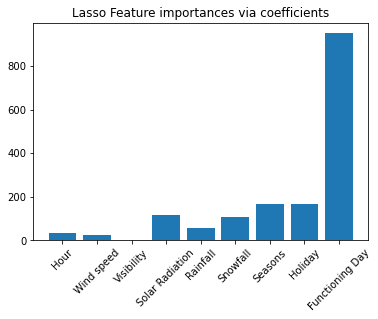

In [49]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

fname = ["Hour", "Wind speed", "Visibility","Solar Radiation", "Rainfall", "Snowfall", "Seasons", "Holiday", 
           "Functioning Day"]
feature_names = np.array(fname)
plt.bar(height=importance.reshape(9), x=feature_names)
plt.xticks(rotation = 45)
plt.title("Lasso Feature importances via coefficients")
plt.show()

In [50]:
lassocv = LassoCV(alphas = arange(0.01, 10, 0.01), cv = 5, max_iter = 100000)
LRModel = lassocv.fit(x_train, y_train)
LRModel.coef_

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 3.55859987e+01, -2.31108146e+01,  1.32274545e-01,  1.17864410e+02,
       -5.60232526e+01, -1.07621519e+02, -1.65480477e+02,  1.66179869e+02,
        9.49829401e+02])

In [51]:
print('alpha: ' + str(LRModel.alpha_))
print('r_squared: ' + str(LRModel.score(x_train,y_train)))

alpha: 0.11
r_squared: 0.3756589743792872


In [52]:
#Add Lasso Regression Predicted Values
Predictions['Lasso Regression'] = LRPred = LRModel.predict(x_test)

In [53]:
# Append RMSE for all the models
ModelNames.append('Lasso Reg')

# Add RMSE
RMSE = np.append(RMSE,mean_squared_error(y_test, LRPred, squared = False))

# Symbolic Regression

In [54]:
# First Test
function_set = ['add', 'sub', 'mul', 'div','neg','inv']
SRModel = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=20, stopping_criteria=138567.488362,
                           metric='mse',
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                          feature_names=x_train.columns)
SRModel.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


C:\Users\kllee\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   0    14.25      5.40559e+20        3           439898           358205      1.67m
   1    13.60      5.95383e+11       21           393834           406306      1.71m
   2    18.09       1.9269e+17       27           343190           334978      1.60m
   3    11.35      7.70916e+10       27           340901           355574      1.35m
   4    18.44      6.20848e+13       27           339988           363788      1.54m
   5    22.07      2.66064e+10       25           338144           390255      1.40m
   6    24.15      3.65546e+11       43           320727           347103      1.36m
   7    28.28      2.54733e+17       43           322543           330760      1.15m
   8    36.70       5.1004e+10       43           318417           370335      1.15m
   9    47.53      9.51911e+13       43           316680           383512      1.22m
  10    46.66      4.40543e+20       46           302228           294726      1.11m
  11    49.57      4.79636e+16       48           299895         

SymbolicRegressor(feature_names=Index(['Hour', 'WindSpeed', 'Visibility', 'SolarRadiation', 'Rainfall',
       'Snowfall', 'Seasons', 'Holiday', 'FunctioningDay'],
      dtype='object'),
                  function_set=['add', 'sub', 'mul', 'div', 'neg', 'inv'],
                  max_samples=0.9, metric='mse', p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0,
                  stopping_criteria=138567.488362, verbose=1)

In [55]:
print('r_squared:',SRModel.score(x_test,y_test))
print(f'Adj_R-Squared: {1 - (1-SRModel.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')

r_squared: 0.3293224370158372
Adj_R-Squared: 0.3258573979418662


In [56]:
#Visualising the symbolic function

converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

SymbolicEqn = sympify(str(SRModel._program), locals=converter)
SymbolicEqn

-FunctioningDay*Seasons*(-FunctioningDay*Hour*(Hour - Seasons) - Hour*SolarRadiation*(Holiday + Hour))/Visibility + 13.6986301369863*Hour + 0.216*Visibility - 13.6986301369863*Holiday/FunctioningDay

In [57]:
#Add Symbolic Regression Predicted Values
y_pred = Predictions['Symbolic Regression'] = SRPred = SRModel.predict(x_test)

In [58]:
# Append RMSE for all the models
ModelNames.append('Symbolic Reg')

# Add RMSE
RMSE = np.append(RMSE,mean_squared_error(y_test, SRPred, squared = False))

# Perceptron (Multi Layer Perceptron)

In [59]:
reg = MLPRegressor(hidden_layer_sizes=(64,32,64),activation="relu" ,random_state=42, max_iter=20000).fit(x_train, y_train)
y_pred = reg.predict(x_test)

C:\Users\kllee\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
Predictions['Perceptron Pred'] = MLPPred=reg.predict(x_test)
y_pred = MLPPred=reg.predict(x_test)

print("R Squared Score: ", (r2_score(y_pred, y_test)))
root_mean_squared_error = math.sqrt(mean_squared_error(y_test,y_pred))
print(f"Root Mean Square Error: {root_mean_squared_error}")
print(f'Adj_R-Squared: {1 - (1-reg.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)}')

R Squared Score:  -0.38047376117090304
Root Mean Square Error: 497.9185028401071
Adj_R-Squared: 0.398490479296417


In [61]:
# Append RMSE for all the models
ModelNames.append('Perceptron')

# Add RMSE
RMSE = np.append(RMSE,mean_squared_error(y_test, MLPPred, squared = False))

# Comparing the predicted values

In [62]:
RMSEData = np.column_stack((ModelNames,RMSE.round(2)))
RMSEData = pd.DataFrame(RMSEData)
RMSEData.columns = ['Model Name', 'RMSE Score']
RMSEData.style.hide_index()

C:\Users\kllee\AppData\Local\Temp\ipykernel_14320\1893729398.py:4: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  RMSEData.style.hide_index()


Model Name,RMSE Score
Linear Reg,516.7
Transformed Reg: sqrt,702.3
Ridge Reg,604.0
Lasso Reg,511.39
Symbolic Reg,527.12
Perceptron,497.92


In [63]:
opred = Predictions.copy()
y_test2 = y_test.copy()
y_test2.reset_index(inplace = True)
Predictions.reset_index(inplace = True)
#Predictions['Actual Y'] = y_test2

<AxesSubplot:>

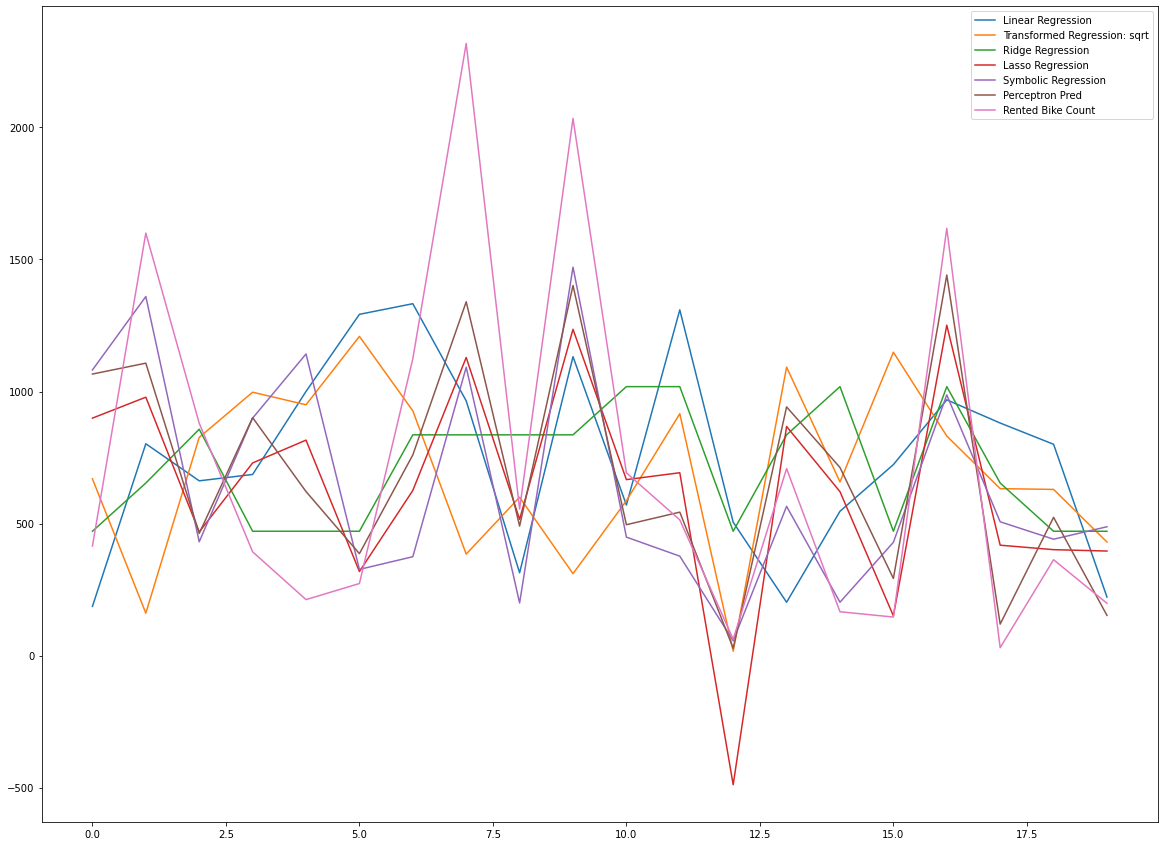

In [64]:
pred = pd.merge(Predictions, y_test2, how = "inner", left_index = True, right_index = True)
pred2 = pred.copy()
del pred["index_x"]
del pred["index_y"]
pred.reset_index(drop=True)[0:20].plot(figsize=(20,15))